<h1><center> Flood Evacuation Project </center></h1>

In [1]:
%matplotlib inline

Import required libraries. Install if necessary.

In [2]:
import cartopy.crs as ccrs
import geopandas as gpd
from IPython.display import clear_output, display, Markdown
from IPython.core.display import HTML
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
import numpy as np
import rasterio
from rasterio.transform import xy, rowcol, from_bounds
from rasterio import features
from rasterio.windows import Window
from rtree import index
from shapely.geometry import Point, LineString, box
import sys
import time 

In [3]:
# Function to insert the user current location 
# Also validating if the input is within the bounds of the area.

def user_location():
    while True:
        x = input('Please input your Easting value between 425,000 and 470,000: ')
        try:
            x = float(x)
        except:
            print('Please Insert a Number')
            continue
        if not (425000 <= x <= 470000):
            print('Please insert a valid Easting value between 425,000 and 470,000')
            continue
        else:
            break
            
    while True:
        y = input('Please input your Northing value between 75,000 and 100,000: ')
        try:
            y = float(y)
        except:
            print('Please Insert a Number')
            continue
        if not (75000 <= y <= 100000):
            print('Please insert a valid Easting value between 75,000 and 100,000')
            continue
        else:
            break
            
    return x, y

In [4]:
# Prompt user to insert their current location.
location = user_location()
location_obj = Point(location)

# Calculate the bounds based on the maximum buffer distance.
buffer_distance = 5000
west_bound, east_bound = location[0] - buffer_distance, location[0] + buffer_distance
south_bound, north_bound = location[1] - buffer_distance, location[1] + buffer_distance

Please input your Easting value between 425,000 and 470,000: 450004
Please input your Northing value between 75,000 and 100,000: 80000


In [5]:
# Load the legend and point component
clear_output()
display(HTML('<h3><span style="color:blue"> loading the necessary files ...\</span></h3>'))
legend_img = mpimg.imread('images/legend.png')
geotag_img = mpimg.imread('images/geotag.png')
geotag_destination_img = mpimg.imread('images/geotag_destination.png')

In [6]:
#Load the ITN file and extract the road_nodes
#Read Network
solent_itn_json = 'material/itn/solent_itn.json'
with open(solent_itn_json) as f:
    solent_itn = json.load(f)
    
roads = solent_itn['road']
road_links = solent_itn['roadlinks']
road_nodes = solent_itn['roadnodes']

In [7]:
#Create a raster window showing the start point as a central point and the buffer distance.
def window(location, raster_layer, buffer_distance):
    row_offset, col_offset = raster_layer.index(west_bound, north_bound)
    row_opposite, col_opposite = raster_layer.index(east_bound, south_bound)
    width = col_opposite - col_offset
    height = row_opposite - row_offset
    window = Window(col_offset, row_offset, width, height)
    return window

In [8]:
# Function to add "padding" around the heights raster to accommodate for 
# the remote location within 5km from the edges of the raster.
def padding(raster, array, location_obj, resolution,
           buffer_distance):
    expected_size = int(buffer_distance/raster.transform[0] * 2)
    if raster.shape == (expected_size, expected_size):
        return array
    else:
        horizontal_diff = expected_size - array.shape[1]
        horizontal_fill = np.empty((array.shape[0], horizontal_diff))
        
        vertical_diff = expected_size - array.shape[0]
        vertical_fill = np.empty((array.shape[0], horizontal_diff))
        
    bounds = raster.bounds
    
    if location_obj.x - bounds.left < buffer_distance:
        array = np.hstack([horizontal_fill, array])
    elif bounds.right - location_obj.x < buffer_distance:
        array = np.hstack([array, horizontal_fill])
    
    if location_obj.x - bounds.left < buffer_distance:
        array = np.hstack([horizontal_fill, array])
    elif bounds.right - location_obj.x < buffer_distance:
        array = np.hstack([array, horizontal_fill])
        
    return array

In [9]:
# Load and read elevation raster as numpy array
elevation_raster_path = 'material/elevation/SZ.asc'
elevation_raster = rasterio.open(elevation_raster_path)
resolution = elevation_raster.transform[0]

elevation_raster_box = box(*list(elevation_raster.bounds))
distance_from_bounds = elevation_raster_box.exterior.distance(location_obj)

window_elevation = window(location, elevation_raster, buffer_distance)
heights_array = elevation_raster.read(1, window=window_elevation)
heights_array = padding(elevation_raster, heights_array, location_obj,
                        resolution, buffer_distance)

#Affine transformation
number_of_columns = (east_bound - west_bound)/elevation_raster.transform[0]
number_of_rows = (north_bound - south_bound)/elevation_raster.transform[0]
heights_affine_for_window = from_bounds(west_bound, south_bound,
                                        east_bound, north_bound,
                                       number_of_columns,
                                       number_of_rows)

In [10]:
# Load and read Island raster
island_raster_path = 'material/os50k/raster-50k_2724246.tif'
island_raster = rasterio.open(island_raster_path)

window_island = window(location, island_raster,buffer_distance)
island_raster_array = island_raster.read(1, window=window_island)
island_raster_array = padding(island_raster, island_raster_array, 
                             location_obj, resolution, buffer_distance)

palette = np.array([value for key, value in island_raster.colormap(1).items()])
island_raster_image = palette[island_raster_array.astype(int)]

In [11]:
#Create rasterised version of the point buffer to clip the heights array
clear_output()
display(HTML('<h3><span style="color:blue"> Performing calculations ...\
              </span></h3>'))
# Location Buffer
location_buffer = location_obj.buffer(buffer_distance)

#Rasterize buffer
number_of_columns = int((east_bound - west_bound) / resolution)
number_of_rows = int((north_bound - south_bound) / resolution)
array_shape = (number_of_rows, number_of_columns)
affine_transform = from_bounds(west_bound, south_bound,
                               east_bound, north_bound,
                               number_of_columns, number_of_rows)
location_buffer_mask = features.rasterize([(location_buffer,1)],
                                      out_shape=array_shape,
                                      transform=affine_transform)
location_buffer_mask = ~location_buffer_mask.astype(bool)

# Clip heights with location buffer
heights_array_clipped = heights_array.copy()
heights_array_clipped[location_buffer_mask] = np.nan

In [12]:
# Locate highest point 
row, col = np.unravel_index(np.nanargmax(heights_array_clipped),
                           heights_array_clipped.shape)
x_highest, y_highest = xy(affine_transform, row, col)
highest_location = (x_highest, y_highest)

In [14]:
# Create an R tree index of all nodes inside the buffer area to find the
# nearest node between the user's location and the highest point
idx = index.Index()
for i, (fid, coords) in enumerate(road_nodes.items()):
    (x,y) = coords['coords']
    node_as_point = Point(x,y)
    if not location_buffer.contains(node_as_point):
        continue
    idx.insert(i, (x,y), fid)
try:
    nearest_origin_point_fid = list(idx.nearest(location, num_results=1, 
                                                objects=True))[0].object
except IndexError as e:
    clear_output()
    display(HTML("<h1><center> It seems that there are no transportation nodes\
                  near you </center></h1>"))
    display(HTML("<h1><center> Please, relocate and refresh the page \
                  </center></h1>"))
    start_point = ("<h2><center>" + "The point you entered is at " +
                   str(int(point[0])) + ", " + str(int(point[1])) +
                   "</center></h2>")
    display(HTML(start_point))
    while True:
        pass
    
nearest_target_point_fid = list(idx.nearest(highest_location,
                                num_results=1, objects=True))[0].object
nearest_target_coords = road_nodes[nearest_target_point_fid]['coords']
nearest_origin_coords = road_nodes[nearest_origin_point_fid]['coords']

In [15]:
# Function to implement the Naismith's rule
def calculate_time(coords, heights_array, affine_transform):
    total_climb = 0
    for i, point in enumerate(coords):
        x,y = location
        if i == 0:
            last_height = heights_array[rowcol(affine_transform, x, y)]
        else:
            height = heights_array[rowcol(affine_transform, x, y)]
            if height > last_height: 
                total_climb += height - last_height
            last_height = height 
    additional_time = total_climb/10
    return additional_time 

In [16]:
# Check whether all links are inside the buffer area
def links_inside_buffer(coords, polygon):
    inside = True 
    for x_y in coords:
        location_obj = Point(x_y)
        if not polygon.contains(location_obj):
            inside = False
            break
        return inside

In [17]:
# Create the network of edges connecting the nodes - calculate travel time
walking_speed = 5 
km_to_meters = 1000
hour_to_minutes = 60
G = nx.DiGraph()
for link in road_links:
    length = road_links[link]['length']
    coords = road_links[link]['coords']
    
    if not links_inside_buffer(coords, location_buffer):
        continue
    
    base_time = length/(walking_speed * km_to_meters) * hour_to_minutes
    
    # Forward
    additional_time = calculate_time(coords, heights_array,
                                                heights_affine_for_window)
    total_time = base_time + additional_time
    G.add_edge(road_links[link]['start'],
               road_links[link]['end'],
               fid=link,
               length=road_links[link]['length'],
               time=total_time)

    # Backward
    additional_time = calculate_time(reversed(coords),
                                                heights_array,
                                                heights_affine_for_window)
    total_time = base_time+additional_time
    G.add_edge(road_links[link]['end'],
               road_links[link]['start'],
               fid=link,
               length=road_links[link]['length'],
               time=total_time)

In [18]:
# Plot shortest path in a GeoDataFrame
def path_to_gpd(path, G, road_links):
    links = []
    geom = []
    for n, each in enumerate(path):
        if n == 0:
            pass
        else:
            link = G.edges[last, each]['fid']
            links.append(link)
            geom.append(LineString(road_links[link]['coords']))
        last = each
        
    path_gpd = gpd.GeoDataFrame({'fid':links, 'geometry':geom})
    return path_gpd

In [19]:
# Find shortest path and convert it to GeoDataFrame
try: 
    shortest_path = nx.dijkstra_path(G,
                                    source = nearest_origin_point_fid,
                                    target = nearest_target_point_fid,
                                    weight = 'time')
except nx.NetworkXNoPath:
    clear_output()
    display(HTML("<h1><center> It seems that the only way is outside\
                  the 5 Km radius</center></h1>"))
    display(HTML("<h1><center> Please, relocate and refresh the page \
                  </center></h1>"))
    start_point = ("<h2><center>" + "The point you entered is at " +
                   str(int(location[0])) + ", " + str(int(location[1])) +
                   "</center></h2>")
    display(HTML(start_point))
    while True:
        pass
shortest_path_gdf = path_to_gpd(shortest_path, G, road_links)

In [23]:
# Adding off road lines
if not shortest_path_gdf.empty:
    start_node_coords = shortest_path_gdf.iloc[0].geometry.coords[0]
    end_node_coords = shortest_path_gdf.iloc[-1].geometry.coords[-1]
    start_line_obj = LineString([location, start_node_coords])
    end_line_obj = LineString([end_node_coords, highest_location])
    off_road_route = gpd.GeoDataFrame({'fid': ['starting_line', 'ending_line'],
                                       'geometry': [start_line_obj,
                                                    end_line_obj]})
else:
    direct_line_obj = LineString([location, highest_location])
    off_road_route = gpd.GeoDataFrame({'fid': ['direct_line'],
                                       'geometry': [direct_line_obj]})    

Defining the extents required for all rasters to be ploted

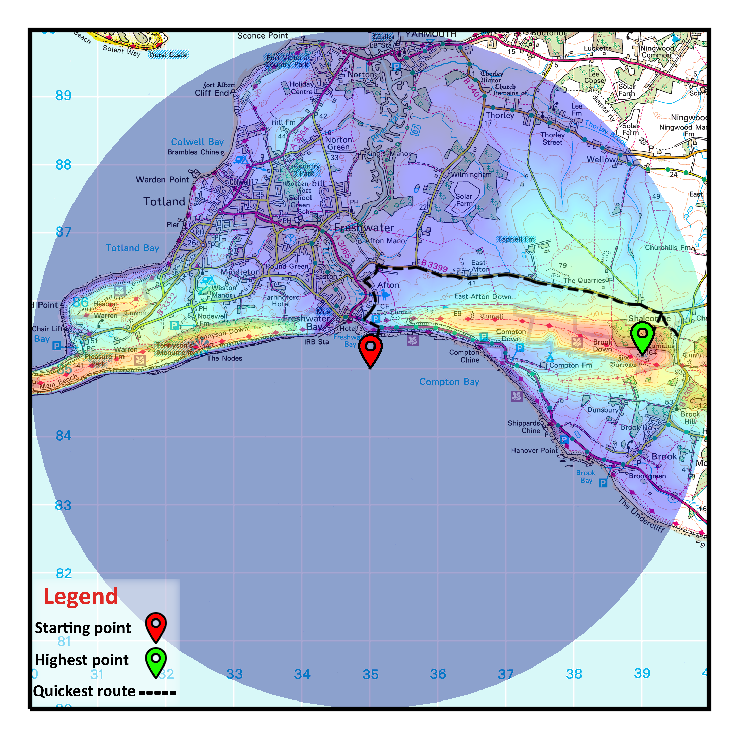

In [24]:
# Defining all needed extents
display_extents = (west_bound, east_bound, south_bound, north_bound)
display(HTML(f'<h3>{display_extents}</h3>'))
legend_extents = (west_bound+50, west_bound+721*3+50,
                  south_bound+50, south_bound+621*3+50)
geotag_extents = (location[0]-177, location[0]+177,
                  location[1], location[1]+512)

geotag_destination_extents = (highest_location[0]-177, highest_location[0]+177,
                              highest_location[1], highest_location[1]+512)


# Plotting
clear_output()
display(HTML('<h3><span style="color:blue"> Exporting graphics ... \
              </span></h3>'))
fig = plt.figure(figsize=(3, 3), dpi=300)

ax = fig.add_subplot(1, 1, 1, projection=ccrs.OSGB())

ax.imshow(island_raster_image,
          origin='upper',
          extent=display_extents,
          transform=ccrs.OSGB(),
          zorder=0)

ax.imshow(heights_array_clipped,
          origin='upper',
          alpha=0.35,
          cmap=cm.jet,
          extent=display_extents,
          transform=ccrs.OSGB(),
          zorder=1)

ax.imshow(legend_img,
          origin='upper',
          extent=legend_extents,
          transform=ccrs.OSGB(),
          zorder=10)

ax.imshow(geotag_img,
          origin='upper',
          extent=geotag_extents,
          transform=ccrs.OSGB(),
          zorder=7)

ax.imshow(geotag_destination_img,
          origin='upper',
          extent=geotag_destination_extents,
          transform=ccrs.OSGB(),
          zorder=7)

shortest_path_gdf.plot(ax=ax,
                       edgecolor='black',
                       linewidth=0.7,
                       linestyle='dashed',
                       transform=ccrs.OSGB(),
                       zorder=6)

off_road_route.plot(ax=ax,
                    edgecolor='black',
                    linewidth=0.7,
                    linestyle='dashed',
                    transform=ccrs.OSGB(),
                    zorder=6)


ax.set_extent(display_extents, crs=ccrs.OSGB())
clear_output()
start_point = ("<h2><center>" + "The point you entered is at " +
               str(int(location[0])) + ", " + str(int(location[1])) +
               "</center></h2>")
end_point = ("<h2><center>" + "Your destination is at " +
             str(int(highest_location[0])) + ", " + str(int(highest_location[1])) +
             "</center></h2>")
display(HTML(start_point))
display(HTML(end_point))
plt.show()
